Part 1

In [1]:
import shutil
try:
    shutil.rmtree("data/property/train")
    shutil.rmtree("data/property/test")
except:
    pass

In [2]:
import os
# ensure directories exist
from pathlib import Path

Path("data/property/train/no_damage").mkdir(parents=True, exist_ok=True)
Path("data/property/train/damage").mkdir(parents=True, exist_ok=True)

Path("data/property/test/no_damage").mkdir(parents=True, exist_ok=True)
Path("data/property/test/damage").mkdir(parents=True, exist_ok=True)

In [3]:
all_no_damage_file_paths = os.listdir('data/no_damage')
all_damage_file_paths = os.listdir('data/damage')

In [4]:
import random

train_no_damage_paths = random.sample(all_no_damage_file_paths, int(len(all_no_damage_file_paths)*0.8))
print("train no_damage image count: ", len(train_no_damage_paths))
test_no_damage_paths = [ p for p in all_no_damage_file_paths if p not in train_no_damage_paths]
print("test no_damage image count: ", len(test_no_damage_paths))
# ensure no overlap:
overlap = [p for p in train_no_damage_paths if p in test_no_damage_paths]
print("len of overlap: ", len(overlap))

train_damage_paths = random.sample(all_damage_file_paths, int(len(all_damage_file_paths)*0.8))
print("train damage image count: ", len(train_damage_paths))
test_damage_paths = [ p for p in all_damage_file_paths if p not in train_damage_paths]
print("test damage image count: ", len(test_damage_paths))
# ensure no overlap:
overlap = [p for p in train_damage_paths if p in test_damage_paths]
print("len of overlap: ", len(overlap))

train no_damage image count:  5721
test no_damage image count:  1431
len of overlap:  0
train damage image count:  11336
test damage image count:  2834
len of overlap:  0


In [5]:
# ensure to copy the images to the directories
import shutil
for p in train_no_damage_paths:
    shutil.copyfile(os.path.join('data/no_damage', p), os.path.join('data/property/train/no_damage', p) )

for p in test_no_damage_paths:
    shutil.copyfile(os.path.join('data/no_damage', p), os.path.join('data/property/test/no_damage', p) )

for p in train_damage_paths:
    shutil.copyfile(os.path.join('data/damage', p), os.path.join('data/property/train/damage', p) )

for p in test_damage_paths:
    shutil.copyfile(os.path.join('data/damage', p), os.path.join('data/property/test/damage', p) )


# check counts:
print("Files in train/no_damage: ", len(os.listdir("data/property/train/no_damage")))
print("Files in train/damage: ", len(os.listdir("data/property/train/damage")))

print("Files in test/no_damage: ", len(os.listdir("data/property/test/no_damage")))
print("Files in test/damage: ", len(os.listdir("data/property/test/damage")))

Files in train/no_damage:  5721
Files in train/damage:  11336
Files in test/no_damage:  1431
Files in test/damage:  2834


In [6]:
pip install tensorflow_datasets --user

Note: you may need to restart the kernel to use updated packages.


In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Path to your actual training data
train_data_dir = 'data/property/train'

batch_size = 32

# Load training dataset (raw, without resizing)
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=batch_size
)

# Load validation dataset (raw, without resizing)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=batch_size
)

# --- Add the investigation cell here --- 
# Inspect a few batches to understand raw image data structure (before any resizing)
for images, labels in train_ds_raw.take(1):
    print("Raw Image batch shape:", images.shape)  # Raw shape before resizing
    print("Raw Label batch shape:", labels.shape)
    print("Raw Image data type:", images.dtype)
    print("Raw Label data type:", labels.dtype)
    print("Raw Min pixel value:", tf.reduce_min(images).numpy())
    print("Raw Max pixel value:", tf.reduce_max(images).numpy())
    print("Unique labels in raw batch:", tf.unique(labels).y.numpy())

2025-04-10 03:14:34.891386: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 03:14:34.942762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 03:14:34.942829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 03:14:34.945296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 03:14:34.955765: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 03:14:34.956299: I tensorflow/core/platform/cpu_feature_guard.cc:1

Found 17057 files belonging to 2 classes.
Using 13646 files for training.
Found 17057 files belonging to 2 classes.
Using 3411 files for validation.
Raw Image batch shape: (32, 256, 256, 3)
Raw Label batch shape: (32,)
Raw Image data type: <dtype: 'float32'>
Raw Label data type: <dtype: 'int32'>
Raw Min pixel value: 0.0
Raw Max pixel value: 255.0
Unique labels in raw batch: [0 1]


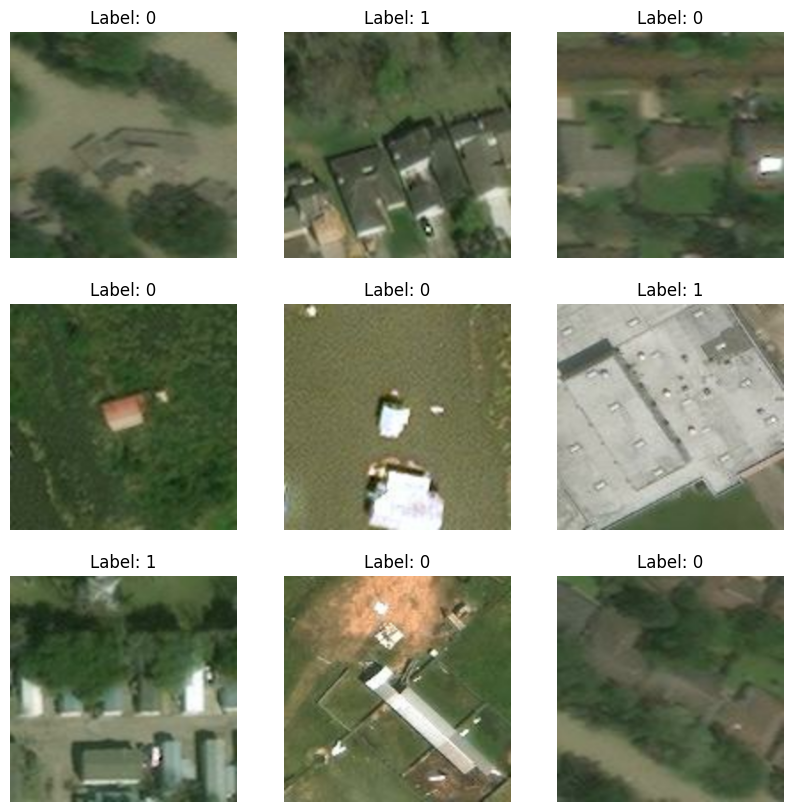

In [8]:
import matplotlib.pyplot as plt

# Load a few sample images from the raw dataset
sample_images, sample_labels = next(iter(train_ds_raw))

# Set up the plot
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images in a 3x3 grid
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))  # Convert tensor to numpy for display
    plt.title(f"Label: {sample_labels[i].numpy()}")
    plt.axis('off')  # Hide the axis for a cleaner display
plt.show()


In [9]:
# import needed classes and functions
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# target image size
img_height = 128
img_width = 128

# note that the subset parameter can take values of "training", "validation", or "both";
# the value dictates which dataset is returned (we want both)
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
# rescale instance
rescale = Rescaling(scale=1.0/255)

# apply the rescale to the train and validation sets
train_rescale_ds = train_ds.map(lambda image,label:(rescale(image),label))
val_rescale_ds = val_ds.map(lambda image,label:(rescale(image),label))

Found 17057 files belonging to 2 classes.
Using 13646 files for training.
Using 3411 files for validation.


In [10]:
# path to test data
test_data_dir = 'data/property/test/'

# we do not set subset=both here because we do not want the test set split
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
)

# approach 1: manually rescale data --
rescale = Rescaling(scale=1.0/255)
test_rescale_ds = test_ds.map(lambda image,label:(rescale(image),label))

Found 4265 files belonging to 2 classes.


Part 2

ANN

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Create a fully connected neural network
model_ann = Sequential()

# Input layer
model_ann.add(Flatten(input_shape=(128, 128, 3)))

# Hidden layers with ReLU activation
model_ann.add(Dense(512, activation='relu'))
model_ann.add(Dense(256, activation='relu'))
model_ann.add(Dense(128, activation='relu'))
model_ann.add(Dense(128, activation='relu'))
model_ann.add(Dense(64, activation='relu'))
model_ann.add(Dense(32, activation='relu'))

# Output layer with sigmoid activation for binary classification (damage vs no damage)
model_ann.add(Dense(1, activation='sigmoid'))

# Finalize the model setup
model_ann.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

# Show architecture
model_ann.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 512)               25166336  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2

In [12]:
history = model_ann.fit(
            train_rescale_ds,
            batch_size=32,
            epochs=20,
            validation_data=val_rescale_ds
)

Epoch 1/20
427/427 [==============================] - 67s 154ms/step - loss: 0.7193 - accuracy: 0.6409 - val_loss: 0.5956 - val_accuracy: 0.6693
Epoch 2/20
427/427 [==============================] - 66s 155ms/step - loss: 0.5920 - accuracy: 0.7017 - val_loss: 0.5617 - val_accuracy: 0.7124
Epoch 3/20
427/427 [==============================] - 66s 155ms/step - loss: 0.5745 - accuracy: 0.7171 - val_loss: 0.5367 - val_accuracy: 0.7467
Epoch 4/20
427/427 [==============================] - 67s 156ms/step - loss: 0.5418 - accuracy: 0.7426 - val_loss: 0.5744 - val_accuracy: 0.6810
Epoch 5/20
427/427 [==============================] - 67s 157ms/step - loss: 0.5332 - accuracy: 0.7441 - val_loss: 0.5390 - val_accuracy: 0.7446
Epoch 6/20
427/427 [==============================] - 67s 157ms/step - loss: 0.5242 - accuracy: 0.7549 - val_loss: 0.6205 - val_accuracy: 0.6857
Epoch 7/20
427/427 [==============================] - 66s 154ms/step - loss: 0.5144 - accuracy: 0.7600 - val_loss: 0.5078 - val_ac

In [13]:
test_loss, test_accuracy = model_ann.evaluate(test_rescale_ds, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.48366954922676086
Test Accuracy: 0.7873387932777405


In [14]:
import os

os.makedirs('./models', exist_ok=True)
model_ann.save('./models/ann.keras')

Lenet-5 CNN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

# Initialize the sequential model
lenet5 = Sequential()

# First convolution + pooling block
lenet5.add(Conv2D(6, (5, 5), activation='relu', input_shape=(128, 128, 3)))
lenet5.add(AveragePooling2D(pool_size=(2, 2)))

# Second convolution + pooling block
lenet5.add(Conv2D(16, (5, 5), activation='relu'))
lenet5.add(AveragePooling2D(pool_size=(2, 2)))

# Flatten feature maps before feeding to dense layers
lenet5.add(Flatten())

# Dense layers to interpret the extracted features
lenet5.add(Dense(120, activation='relu'))
lenet5.add(Dense(84, activation='relu'))

# Final layer with sigmoid activation for binary output (1 = damage, 0 = no damage)
lenet5.add(Dense(1, activation='sigmoid'))

# Compile model
lenet5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the structure of the model
lenet5.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 62, 62, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 13456)             0         
                                                                 
 dense_7 (Dense)             (None, 120)              

In [16]:
history = lenet5.fit(
            train_rescale_ds,
            batch_size=32,
            epochs=20,
            validation_data=val_rescale_ds
)

Epoch 1/20
427/427 [==============================] - 44s 100ms/step - loss: 0.3653 - accuracy: 0.8430 - val_loss: 0.2924 - val_accuracy: 0.8804
Epoch 2/20
427/427 [==============================] - 42s 98ms/step - loss: 0.2411 - accuracy: 0.9028 - val_loss: 0.2292 - val_accuracy: 0.9056
Epoch 3/20
427/427 [==============================] - 42s 99ms/step - loss: 0.1870 - accuracy: 0.9245 - val_loss: 0.2094 - val_accuracy: 0.9159
Epoch 4/20
427/427 [==============================] - 42s 98ms/step - loss: 0.1330 - accuracy: 0.9482 - val_loss: 0.1964 - val_accuracy: 0.9241
Epoch 5/20
427/427 [==============================] - 42s 98ms/step - loss: 0.0980 - accuracy: 0.9622 - val_loss: 0.2112 - val_accuracy: 0.9305
Epoch 6/20
427/427 [==============================] - 42s 98ms/step - loss: 0.0745 - accuracy: 0.9736 - val_loss: 0.2553 - val_accuracy: 0.9211
Epoch 7/20
427/427 [==============================] - 42s 97ms/step - loss: 0.0799 - accuracy: 0.9731 - val_loss: 0.3448 - val_accuracy

In [17]:
test_loss, test_accuracy = lenet5.evaluate(test_rescale_ds, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.6115264892578125
Test Accuracy: 0.911840558052063


In [18]:
lenet5.save('./models/lenet5.keras')

Alternate LeNet-5 CNN Architecture

In [19]:
from tensorflow.keras.layers import MaxPooling2D, Dropout, Conv2D
from keras import optimizers

altlenet5 = Sequential()

altlenet5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
altlenet5.add(MaxPooling2D((2, 2)))
altlenet5.add(Conv2D(64, (3, 3), activation='relu'))
altlenet5.add(MaxPooling2D((2, 2)))
altlenet5.add(Conv2D(128, (3, 3), activation='relu'))
altlenet5.add(MaxPooling2D((2, 2)))
altlenet5.add(Conv2D(128, (3, 3), activation='relu'))
altlenet5.add(MaxPooling2D((2, 2)))

# Flatten the feature maps to feed into fully connected layers
altlenet5.add(Flatten())

altlenet5.add(Dropout(0.5))

altlenet5.add(Dense(512, activation='relu'))
altlenet5.add(Dense(1, activation='sigmoid'))

# Compile model
altlenet5.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
altlenet5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)      

In [20]:
history = altlenet5.fit(
            train_rescale_ds,
            batch_size=32,
            epochs=20,
            validation_data=val_rescale_ds
)

Epoch 1/20
427/427 [==============================] - 93s 215ms/step - loss: 0.3950 - accuracy: 0.8208 - val_loss: 0.1867 - val_accuracy: 0.9267
Epoch 2/20
427/427 [==============================] - 91s 214ms/step - loss: 0.1978 - accuracy: 0.9279 - val_loss: 0.2197 - val_accuracy: 0.9085
Epoch 3/20
427/427 [==============================] - 90s 210ms/step - loss: 0.1346 - accuracy: 0.9473 - val_loss: 0.1209 - val_accuracy: 0.9540
Epoch 4/20
427/427 [==============================] - 91s 213ms/step - loss: 0.1306 - accuracy: 0.9521 - val_loss: 0.1092 - val_accuracy: 0.9540
Epoch 5/20
427/427 [==============================] - 91s 213ms/step - loss: 0.1101 - accuracy: 0.9585 - val_loss: 0.1929 - val_accuracy: 0.9267
Epoch 6/20
427/427 [==============================] - 91s 213ms/step - loss: 0.1011 - accuracy: 0.9615 - val_loss: 0.1138 - val_accuracy: 0.9499
Epoch 7/20
427/427 [==============================] - 92s 216ms/step - loss: 0.0851 - accuracy: 0.9669 - val_loss: 0.0874 - val_ac

In [21]:
test_loss, test_accuracy = altlenet5.evaluate(test_rescale_ds, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.0984039381146431
Test Accuracy: 0.9723329544067383


In [22]:
altlenet5.save('./models/altlenet5.keras')